# Proyecto 2: Clustering
En este proyecto, aplicaremos los algoritmos de *clustering* para segmentar tumores en cerebros humanos. Los algoritmos a utilizar son: *K-means*, *DBScan* y *GMM*.

In [30]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.neighbors import KDTree
import gdown
from PIL import Image, ImageOps
from scipy.spatial import distance
from scipy.stats import multivariate_normal
import seaborn as sns
import os
import json
from math import log
from sklearn.metrics import DistanceMetric
import os
from sklearn.neighbors import BallTree
from IPython.display import display

## Base de datos

Con el siguiente fragmento, descargamos y descomprimimos el *dataset*, el cual se encuentra descargado en el repositorio.

In [2]:
'''url =  'https://drive.google.com/uc?id=1j_EDWso-zm5wcPQMpdwKyIg1ZuD7jeBI&export=download'
output = 'datos.zip'
gdown.download(url, output, quiet=False)

with ZipFile('datos.zip', 'r') as zipObj: # Extract all the contents of zip file in current directory 
  zipObj.extractall()'''

"url =  'https://drive.google.com/uc?id=1j_EDWso-zm5wcPQMpdwKyIg1ZuD7jeBI&export=download'\noutput = 'datos.zip'\ngdown.download(url, output, quiet=False)\n\nwith ZipFile('datos.zip', 'r') as zipObj: # Extract all the contents of zip file in current directory \n  zipObj.extractall()"

## Implementación de los algoritmos
Implementamos los métodos en clases para usarlos más adelante.

In [3]:
class Kmeans:
    def __init__(self, k, distance_type = 'euclidian'):
        self.k = k
        self.distance_type = distance_type
        self.reset()
    
    def reset(self):
        self.n = 0
        self.m = 0
        self.umbral = 0
        self.init_type = 'random'
        self.data = None
        self.labels = None
        self.centroids = None

    def distance(self, x, y):
        if self.distance_type == 'minkowski':
            return distance.minkowski(x,y)
        elif self.distance_type == 'manhattan':
            return distance.cityblock(x, y)
        else: #Euclidian default
            return distance.euclidean(x,y)

    def min_index_distance(self, x): #Retorna el índice del centroide más cercano a x
        distances = np.array( [self.distance(x, centroid) for centroid in self.centroids] )
        return np.argmin(distances)

    def label(self): #Etiqueta a los datos de data
        self.labels = np.array([ self.min_index_distance(x) for x in self.data ])

    def update(self):
        new_centroids = np.zeros((self.k, self.m), dtype = np.float64)
        labels_n = np.zeros(self.k, dtype = np.float64)
        for i in range(self.n):
            new_centroids[self.labels[i]] += self.data[i]
            labels_n[self.labels[i]] += 1
        for i in range(self.k):
            if labels_n[i] != 0:
                new_centroids[i] /= labels_n[i]
        return new_centroids

    def distance_to_zero(self, x):
        z = np.zeros(x.shape[0], dtype = int)
        return self.distance(x, z)

    def init(self):
        if self.init_type == 'kmeans++':
            dist_to_zero = []
            for i in range(self.n):
                dist_to_zero.append(self.distance_to_zero(self.data[i]))
            init_centroids = [self.data[ np.argmin(np.array(dist_to_zero)) ] ]
            for centroid_i in range(self.k-1):
                dist = []
                for i in range(self.n):
                    dist_i = np.array( [self.distance(self.data[i], centroid) for centroid in init_centroids] )
                    dist.append(np.amin(dist_i))
                next_centroid = self.data[ np.argmax(np.array(dist)) ]
                init_centroids.append(next_centroid)
            self.centroids = np.array(init_centroids, dtype = np.float64)
        else: #Random por defecto
            idx = np.random.choice(self.n, self.k, replace = False)
            self.centroids = self.data[idx]

    def fit(self, data, init_type = 'random', umbral = 1e-9):
        self.reset()
        self.umbral = umbral
        self.data = data
        self.n = data.shape[0]
        self.m = data.shape[1]
        self.init_type = init_type

        self.init()
        
        '''record_centroids = []
        for record_i in range(k):
            record_centroids.append([])
        for record_i in range(k):
            record_centroids[record_i].append(centroids[record_i])'''
        
        #print("centroids shape: ", self.centroids.shape)
        #print(np.transpose(self.centroids), "\n")
        i = 0
        while(1):
            i = i + 1
            self.label() #Etiquetar los datos en base a los centroides
            new_centroids = self.update()  #Actualiza los nuevos centroides
            #for record_i in range(k):
                #record_centroids[record_i].append(centroids[record_i])
            if np.all(np.absolute(self.centroids - new_centroids) < umbral):
                self.centroids = new_centroids
                break
            self.centroids = new_centroids
        print(i, "iterations")
    
    def get_labels(self):
        return self.labels
    
    def get_centroids(self):
        return self.centroids


In [4]:
class DBScan:
    def __init__(self, r, threshold, distance_type = 'euclidean'):
        self.r = r
        self.threshold = threshold
        self.distance_type = distance_type
        self.reset()

    def __get_flags(self):
        flags = {
            "undefined": int(-1), 
            "noise": int(-2)
        }
        return flags

    def __init(self):
        self.__init_labels()
        leaf_size = 40
        self.__build_kdtree(leaf_size)   

    # Etiqueta a todos los puntos como "undefined"
    def __init_labels(self):
        self.labels = dict()
        flags = self.__get_flags()
        for i in range(len(self.data)):
            self.labels[i] = flags["undefined"]

    def __build_kdtree(self, leaf_size):
        self.kdtree = KDTree(self.data, leaf_size = leaf_size, metric = DistanceMetric.get_metric(self.distance_type))

    def reset(self):
        self.data = None
        self.labels = None

    def get_labels(self):
        return np.array(list(self.labels.values()))

    def fit(self, data):
        self.reset()
        self.data = data
        self.__init()  
        flags = self.__get_flags()
        c = 0

        for i in range(len(data)):
            if self.labels[i] != flags["undefined"]:
                continue
            neighbors = self.kdtree.query_radius([self.data[i]], r = self.r)[0]
            if len(neighbors) < self.threshold:
                self.labels[i] = flags["noise"]
                continue
            self.labels[i] = c
            for q in neighbors:
                if(np.array_equal(self.data[q], self.data[i])):
                    continue
                if self.labels[q] == flags["noise"]:
                    self.labels[q] = c
                if self.labels[q] != flags["undefined"]:
                    continue
                neighbors_iter = self.kdtree.query_radius([self.data[q]], r = self.r)[0]
                self.labels[q] = c
                if len(neighbors_iter) < self.threshold:
                    continue
                np.append(neighbors,neighbors_iter)
            c += 1
        print(c, "iterations")

In [5]:
class GMM:
    def __init__(self, K):
        self.K = K
        self.reset()
    
    def reset(self):
        self.n = 0
        self.m = 0
        self.labels = []

    def fit(self, data, iterations = 100, umbral = 1e-6):
        while(1):
            try:
                self.reset()
                self.n = data.shape[0]
                self.m = data.shape[1]
                pi = np.array([1.0/self.K for i in range(self.K)], dtype = np.float64)
                mu = np.random.rand(self.K, self.m)
                cov = []
                for i in range(self.K):
                    cov.append(np.cov(np.transpose(data)))
                cov = np.array(cov)
                likelihood = 0.0

                gamma = np.zeros((self.n, self.K), dtype = np.float64)
                
                iteration = 0
                while iteration < iterations:
                    # E step
                    for i in range(self.n):
                        total = 0.0
                        for k in range(self.K):
                            total = total + pi[k]*multivariate_normal.pdf(data[i], mean=mu[k], cov=cov[k])
                        for k in range(self.K):
                            gamma[i][k] = pi[k]*multivariate_normal.pdf(data[i], mean=mu[k], cov=cov[k]) / total
                    
                    # M step
                    N = np.sum(gamma, axis = 0)
                    
                    mu_new = np.zeros((self.K, self.m), dtype = np.float64)
                    for i in range(self.K):
                        for j in range(self.m):
                            mu_new[i][j] = np.dot( np.transpose(gamma)[i], np.transpose(data)[j] )
                        mu_new[i] /= N[i]
                    cov_new = []
                    for k in range(self.K):
                        cov_new_k = np.zeros((self.m, self.m), dtype = np.float64)
                        for i in range(self.n):
                            new_mx = np.matmul( np.transpose([data[i] - mu_new[k]]), [data[i] - mu_new[k]] )
                            new_mx = new_mx * gamma[i][k]
                            cov_new_k = cov_new_k + new_mx
                        cov_new_k = cov_new_k / N[k]
                        cov_new.append(cov_new_k)
                    cov_new = np.array(cov_new)
                    pi_new = N / self.n
                    
                    mu = mu_new
                    cov = cov_new
                    pi = pi_new

                    # Evaluate likelihood
                    likelihood_new = 0.0
                    for i in range(self.n):
                        likelihood_k = 0.0
                        for k in range(self.K):
                            likelihood_k += pi[k] * multivariate_normal.pdf(data[i], mean=mu[k], cov=cov[k])
                        likelihood_new += log(likelihood_k)
                    
                    if abs(likelihood - likelihood_new) < umbral:
                        likelihood = likelihood_new
                        break
                    likelihood = likelihood_new
                    iteration += 1
                print(iteration, "iterations")
                for i in range(self.n):
                    self.labels.append(np.argmax(gamma[i]))
                self.labels = np.array(self.labels)
                break
            except Exception as e:
                print(e.__class__)
                if str(e) == 'singular matrix':
                    print("Singular matrix error. Repeating\n")
                    continue
                else:
                    break
        
    
    def get_labels(self):
        return self.labels

Creamos una función *draw*, que nos permitirá identificar el cluster que mejor represente a la imagen.

In [6]:
def draw(x, y, h, w, all = False, cluster_fixed = -1, centroids = [], record_centroids = []): 
    markers = ['o', '<', 's', '*', 'h', 'p', 'v', '>']
    colors = ['b', 'g', 'm', 'c', 'y']
    k = len(x[0])
    
    s_points = 10
    if len(centroids) > 0:
        s_points = 2

    clusters = set(y)
    if -1 in clusters:
        plt.scatter(x[y == -1, 0], x[y == -1, 1], s = s_points, c = 'black', label = 'Undefined')
        clusters.remove(-1)
    clusters = list(clusters)
    
    im = 0
    ic = 0
    if cluster_fixed != -1 or all == True:
        fig = plt.gcf()
        plt.xlim(0, w)
        plt.ylim(0, h)
        if all == True:
            fig.set_size_inches(10, 10)
            ic = 0
            for cluster in clusters:
                plt.scatter(x[y == cluster, 0], x[y == cluster, 1], s = 100, c = colors[ic], marker = 'o')
                ic += 1
                if ic == len(colors):
                    ic = 0
            plt.show()
        else:
            fig.set_size_inches(4, 4)
            plt.scatter(x[y != cluster_fixed, 0], x[y != cluster_fixed, 1], s = s_points, c = 'b', marker = 'o', alpha = 0.05)
            plt.scatter(x[y == cluster_fixed, 0], x[y == cluster_fixed, 1], s = s_points, c = 'r', marker = 'o')
            plt.show()
    else:
        for cluster_c in clusters:
            fig = plt.gcf()
            fig.set_size_inches(4, 4)
            plt.xlim(0, w)
            plt.ylim(0, h)
            ic = 0
            for cluster in clusters:
                plt.scatter(x[y == cluster, 0], x[y == cluster, 1], s = s_points, c = colors[ic], marker = 'o', alpha = 0.1)
                ic += 1
                if ic == len(colors):
                    ic = 0
            plt.scatter(x[y == cluster_c, 0], x[y == cluster_c, 1], s = s_points, c = 'r', marker = 'o')
            print("cluster:", cluster_c)
            plt.show()

## Segmentación de los tumores
Cargamos los nombres de los archivos en una lista. Procesaremos las imágenes desde 0 hasta 269. Las otras imágenes se usarán para las consultas.

In [7]:
path_project = os.getcwd() + "/"
path = path_project + 'dataset/'
img_names = []
for file in os.listdir(path):
    if os.path.isfile(os.path.join(path, file)) and file.endswith('.jpg'):
        img_names.append(file)
img_names.sort()
print(len(img_names))

302


Por cada imagen, realizamos el siguiente proceso:
- Cargamos la imagen en un vector característico de 3 dimensiones: *posición x*, *posición y* y *color*.
- Generamos el modelo y lo aplicamos a la imagen. Dibujamos todos los *clusters*.
- Seleccionamos el *cluster* que más represente al tumor, y lo guardamos en el archivo *.json* correspondiente.

In [84]:
i_image = 0
w = 50
h = 50
image = Image.open(path + img_names[i_image])
image = image.resize((h, w))
image = ImageOps.grayscale(image)
arr_image = np.array(image)
#image.show()
x_data = []
for i in range(arr_image.shape[0]):
  for j in range(arr_image.shape[1]):
    x_data.append([j, arr_image.shape[0] - i, arr_image[i][j]])
x_data = np.array(x_data)
print(img_names[i_image])

0.jpg


20 iterations


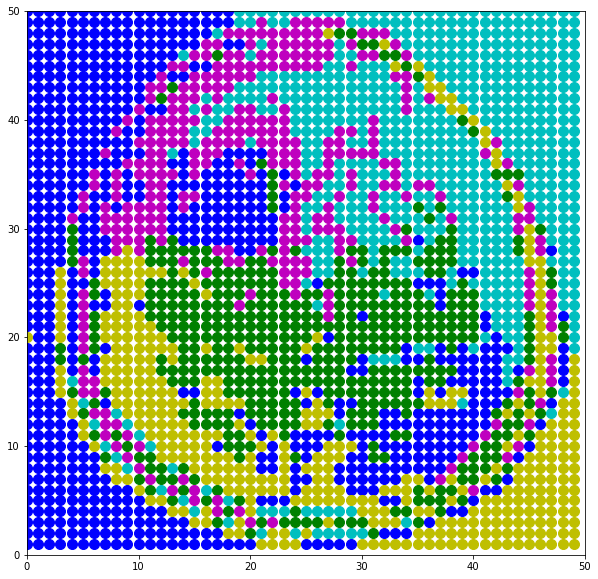

In [85]:

# Para Kmeans
kmeans = Kmeans(k = 25)
kmeans.fit(x_data, init_type = 'kmeans++')
labels = kmeans.get_labels()
'''

# Para DBScan
dbscan = DBScan(24, 10)
dbscan.fit(x_data)
labels = dbscan.get_labels()

# Para GMM
gmm = GMM(20)
gmm.fit(x_data, 100, 1e-2)
labels = gmm.get_labels()
'''

# Para dibujar los clusters, se puede pasar un parámetro más para dibujar un solo cluster
draw(x_data, labels, w, h, True)  #draw(x_data, labels, w, h, cluster)

cluster: 0


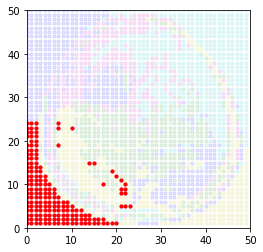

cluster: 1


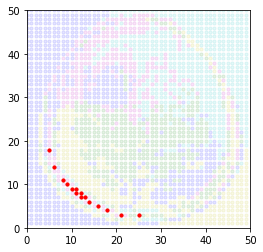

cluster: 2


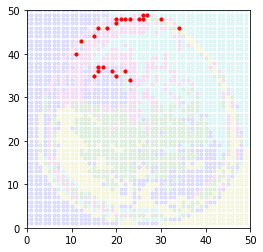

cluster: 3


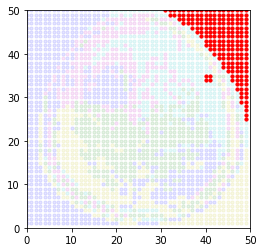

cluster: 4


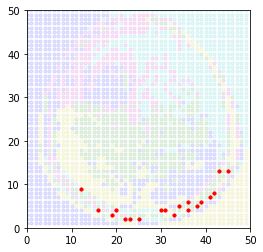

cluster: 5


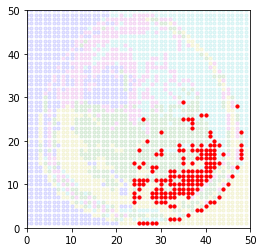

cluster: 6


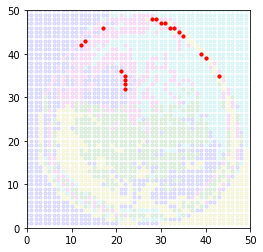

cluster: 7


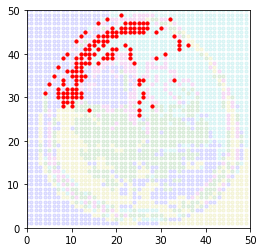

cluster: 8


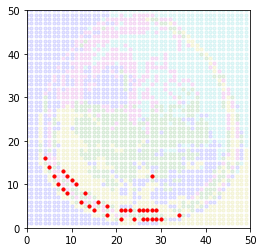

cluster: 9


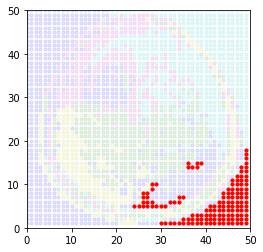

cluster: 10


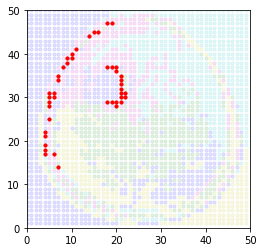

cluster: 11


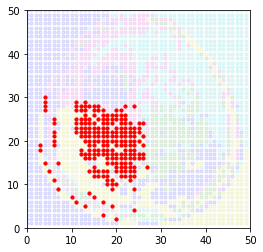

cluster: 12


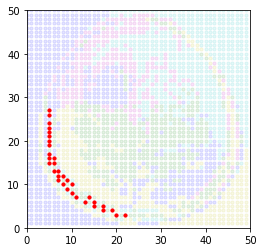

cluster: 13


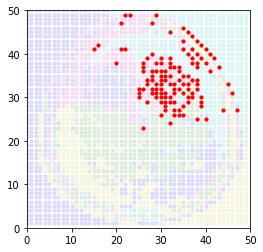

cluster: 14


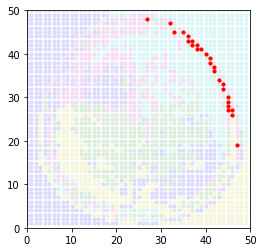

cluster: 15


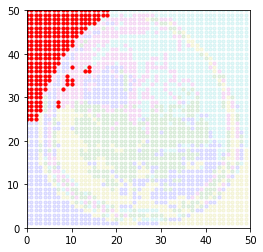

cluster: 16


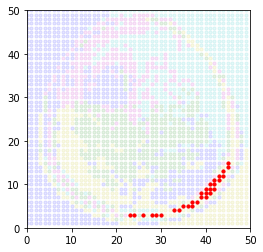

cluster: 17


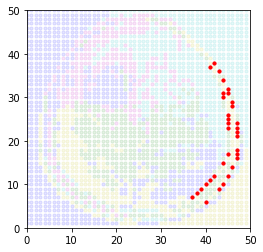

cluster: 18


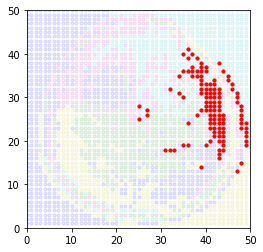

cluster: 19


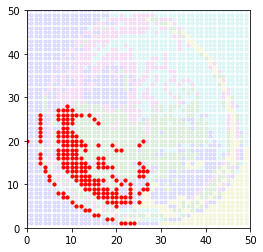

cluster: 20


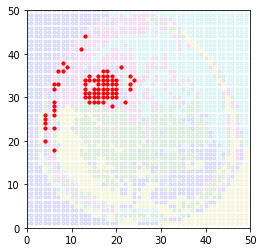

cluster: 21


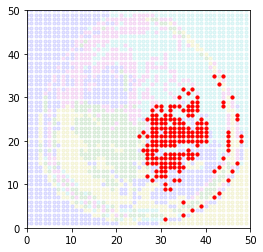

cluster: 22


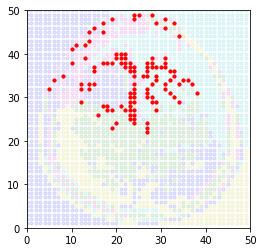

cluster: 23


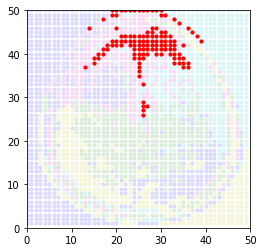

cluster: 24


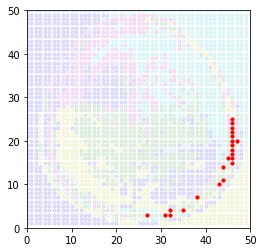

In [86]:
draw(x_data, labels, w, h, False)  #draw(x_data, labels, w, h, cluster)

Con el siguiente código, enviamos los pixeles correspondientes al cluster seleccionado al archivo correspondiente.

In [15]:
cluster = 3

#path_json = path_project + 'data_Kmeans.json'
#path_json = path_project + 'data_DBScan.json'
#path_json = path_project + 'data_GMM.json'
'''
if not os.path.exists(path_json):
   open(path_json, 'a').close()
filesize = os.path.getsize(path_json)

matriz = x_data[labels == cluster]
data = {"name": img_names[i_image], "points": matriz.shape[0], "vector": matriz.tolist()}
if filesize == 0:
   dic = {"n_data": 1, "data": [data]}
   with open(path_json, "w+") as of:
      json.dump(dic,of)
else:
   with open(path_json) as f:
      obj = json.load(f) 
   obj["data"].append(data)
   obj["n_data"] += 1
   with open(path_json, "w+") as of:
      json.dump(obj,of)
'''

## Homogenización de los vectores característicos e indexación
Una vez obtenida toda la información, homogenizamos los vectores característicos de los tumores y utilizamos un Ball Tree para indexarlos.

Función para convertir un vector característico de n dimensiones en x dimensiones

In [9]:
def homogenize_3d(vector, x):
    n = len(vector)
    if n < x:
        while len(vector) < x:
            vector = np.append(vector, vector)
        vector = vector[:x]
    elif n > x:
        vector = vector.reshape(len(vector)//3, 3)
        vector_mean = np.mean(vector, axis = 0)
        tree = BallTree(vector, leaf_size=2,metric='euclidean')
        d, ind = tree.query([vector_mean], k=x//3)
        ind = ind[0]
        ind.sort()
        vector = vector[ind]
        vector = vector.flatten()
    return vector

### Homogenización por media de datos
Calculamos cuántos datos en promedio tienen los tumores de la data en el archivo json a través de un promedio ponderado, y usamos la función para homogenizarlos a esa media. Al final, obtendremos todos los vectores característicos de la misma dimensión.

In [12]:
# Para data_Kmeans.json
path_json = path_project + 'data_Kmeans.json'
with open(path_json, 'r') as f:
   obj = json.load(f)
d = dict()
for o in obj["data"]:
    if len(o["vector"]) in d:
        d[len(o["vector"])] += 1
    else:
        d[len(o["vector"])] = 1
n = 0
t = 0
for k, v in d.items():
    n += v
    t += k * v
media_Kmeans = t // n
media_Kmeans *= 3

data_Kmeans = []
for it in obj["data"]:
    vector = np.array(it["vector"])
    vector = vector.flatten()
    vector = homogenize_3d(vector, media_Kmeans)
    data_Kmeans.append(vector)
data_Kmeans = np.array(data_Kmeans)

#Para data_DBScan
path_json = path_project + 'data_DBScan.json'
with open(path_json, 'r') as f:
   obj = json.load(f)
d = dict()
for o in obj["data"]:
    if len(o["vector"]) in d:
        d[len(o["vector"])] += 1
    else:
        d[len(o["vector"])] = 1
n = 0
t = 0
for k, v in d.items():
    n += v
    t += k * v
media_DBScan = t // n
media_DBScan *= 3


data_DBScan = []
for it in obj["data"]:
    vector = np.array(it["vector"])
    vector = vector.flatten()
    vector = homogenize_3d(vector, media_DBScan)
    data_DBScan.append(vector)
data_DBScan = np.array(data_DBScan)

print("data_Kmeans:", data_Kmeans.shape, "con media", media_Kmeans//3)
print("data_DBScan:", data_DBScan.shape, "con media", media_DBScan//3)

data_Kmeans: (265, 201) con media 67
data_DBScan: (257, 231) con media 77


Como se observa, homogenizamos todos los vectores característicos a un tamaño $media \times 3$

In [14]:
treeKmeans = BallTree(data_Kmeans, leaf_size=2, metric='euclidean')
treeDBScan = BallTree(data_DBScan, leaf_size=2, metric='euclidean')

### Consultas
Realizamos el mismo procedimiento para las nuevas imágenes, desde el índice 270 en adelante. Extraemos el tumor con alguna técnica y consultamos las imágenes con tumores más similares. El programa solicita ingresar el cluster que represente al tumor y consulta en la base de datos por los más parecidos.

In [35]:
def query(img_names, i_image, w, h, tree, path_json, x, method, k = 25, r = 24, th = 10):
    image = Image.open(path + img_names[i_image])
    image = image.resize((h, w))
    image = ImageOps.grayscale(image)
    arr_image = np.array(image)
    image.show()
    x_data = []
    for i in range(arr_image.shape[0]):
        for j in range(arr_image.shape[1]):
            x_data.append([j, arr_image.shape[0] - i, arr_image[i][j]])
    x_data = np.array(x_data)
    print(img_names[i_image])

    if method == "Kmeans":
        kmeans = Kmeans(k)
        kmeans.fit(x_data, init_type = 'kmeans++')
        labels = kmeans.get_labels()
    else:
        dbscan = DBScan(r, th)
        dbscan.fit(x_data)
        labels = dbscan.get_labels()
    draw(x_data, labels, w, h)
    cluster = int(input("Cluster seleccionado: "))
    
    matriz = x_data[labels == cluster]
    vector = matriz.flatten()
    vector = homogenize_3d(vector, x)
    
    dist, ind = tree.query([vector], k=5)
    with open(path_json) as f:
        obj = json.load(f)
    ind = ind[0]
    for i in ind:
        name = obj["data"][i]["name"]
        image = Image.open(path + name)
        image = ImageOps.grayscale(image)
        print(name)
        display(image)

In [38]:
path_Kmeans = path_project + 'data_Kmeans.json'
path_DBScan = path_project + 'data_DBScan.json'

369.jpg
21 iterations
cluster: 0


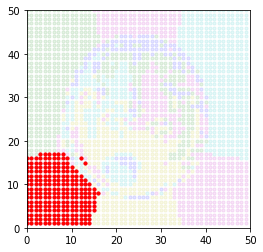

cluster: 1


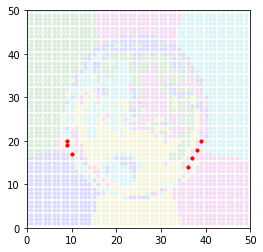

cluster: 2


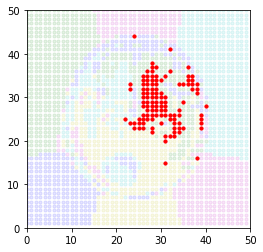

cluster: 3


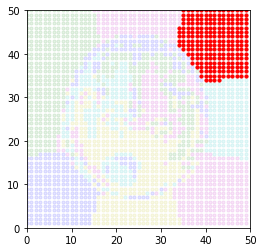

cluster: 4


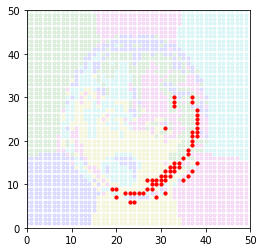

cluster: 5


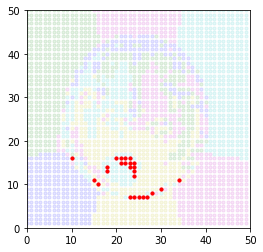

cluster: 6


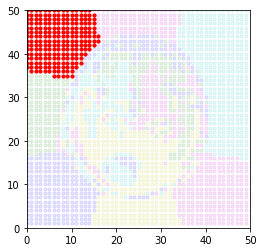

cluster: 7


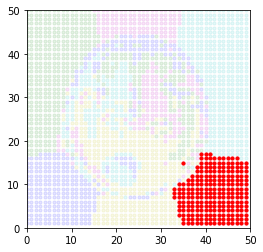

cluster: 8


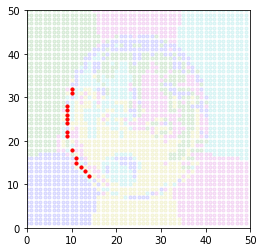

cluster: 9


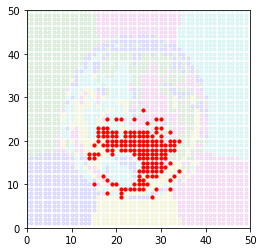

cluster: 10


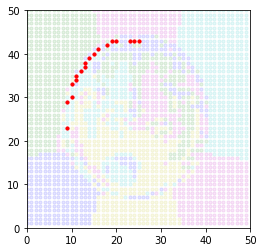

cluster: 11


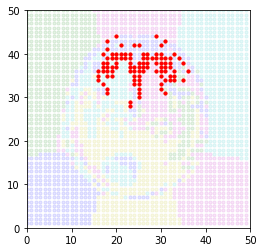

cluster: 12


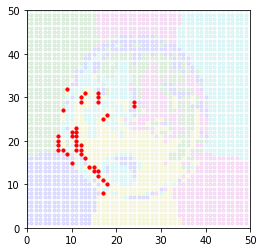

cluster: 13


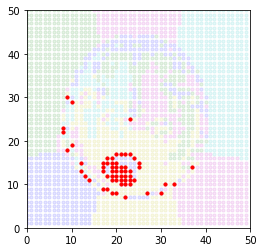

cluster: 14


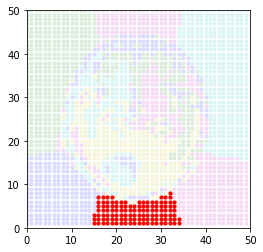

cluster: 15


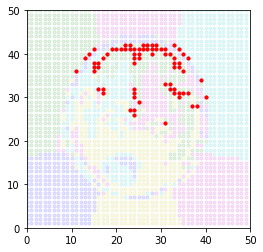

cluster: 16


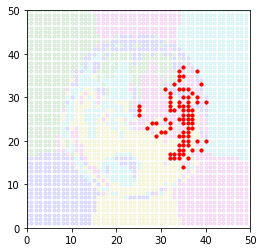

cluster: 17


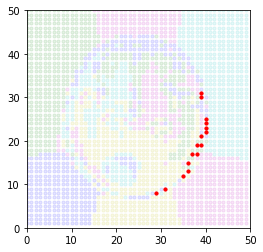

cluster: 18


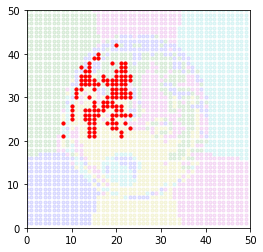

cluster: 19


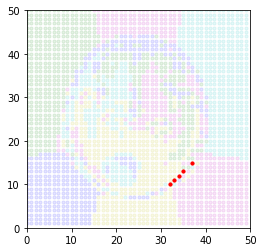

cluster: 20


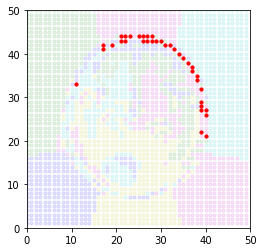

cluster: 21


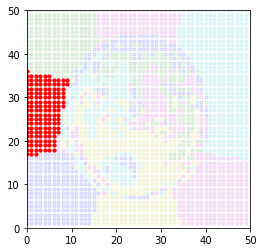

cluster: 22


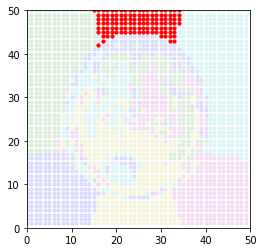

cluster: 23


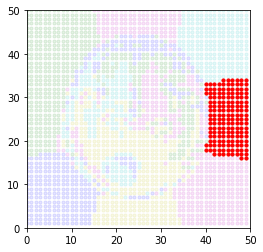

cluster: 24


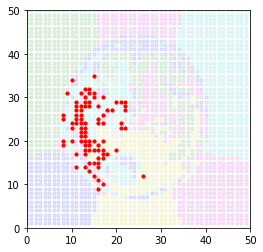

326.jpg


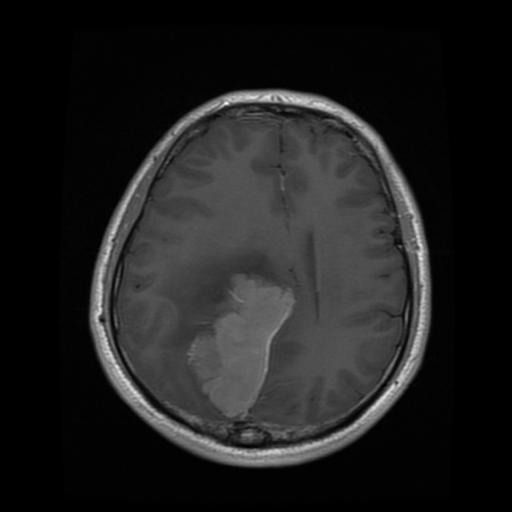

205.jpg


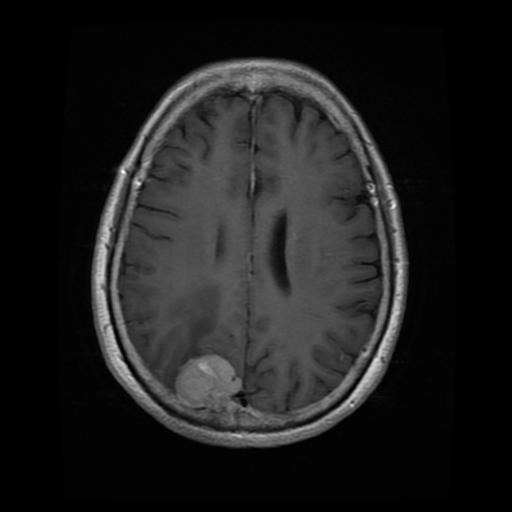

367.jpg


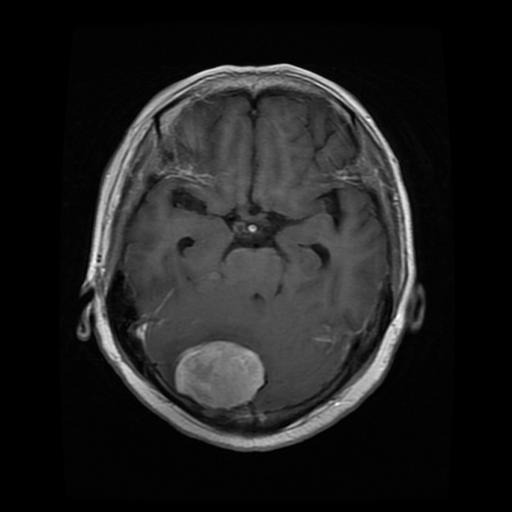

288.jpg


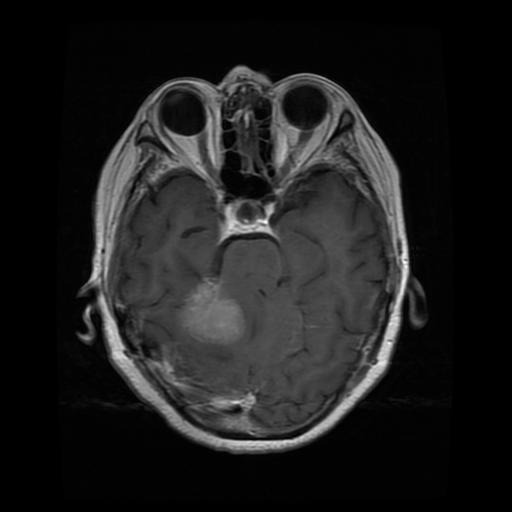

150.jpg


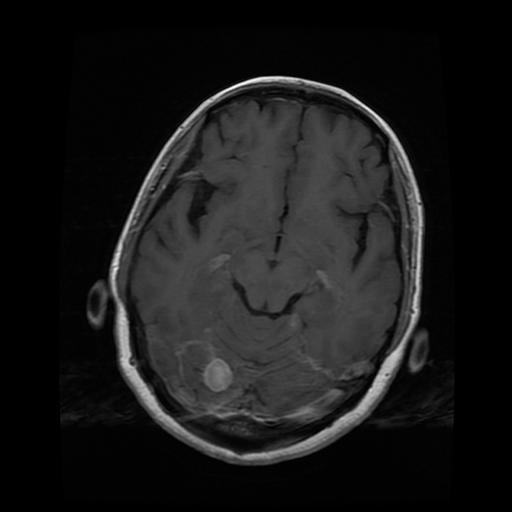

In [36]:
query(img_names, 271, 50, 50, treeKmeans, path_Kmeans, media_Kmeans, "Kmeans")

383.jpg
16 iterations
cluster: 0


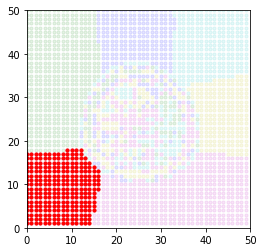

cluster: 1


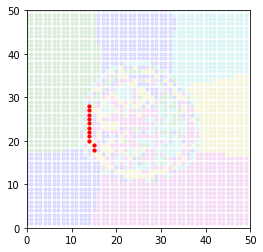

cluster: 2


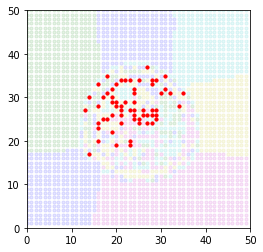

cluster: 3


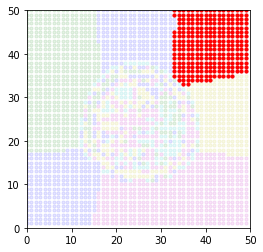

cluster: 4


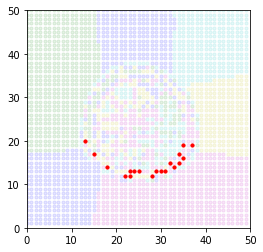

cluster: 5


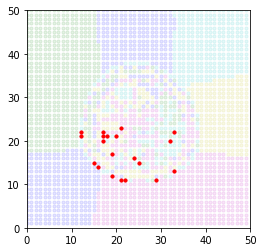

cluster: 6


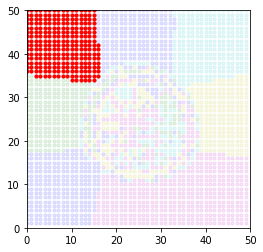

cluster: 7


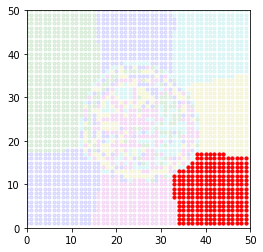

cluster: 8


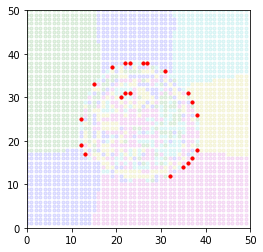

cluster: 9


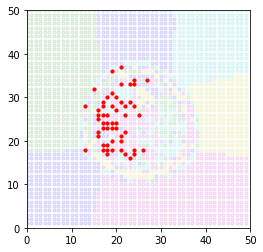

cluster: 10


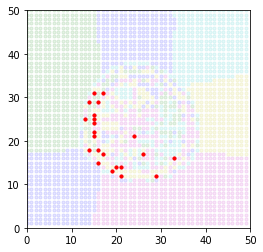

cluster: 11


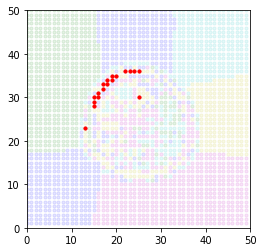

cluster: 12


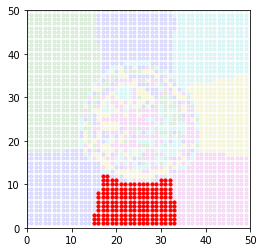

cluster: 13


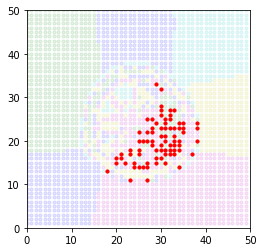

cluster: 14


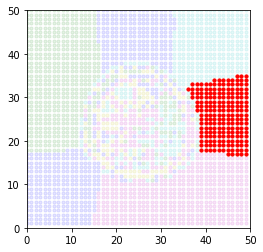

cluster: 15


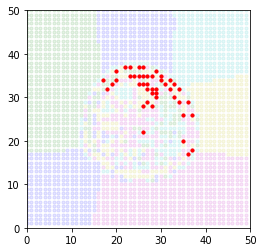

cluster: 16


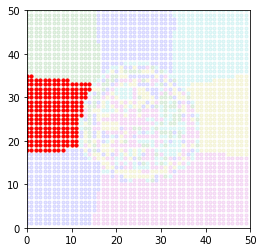

cluster: 17


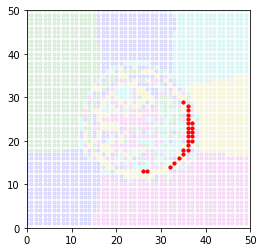

cluster: 18


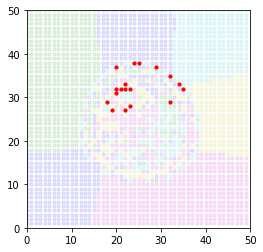

cluster: 19


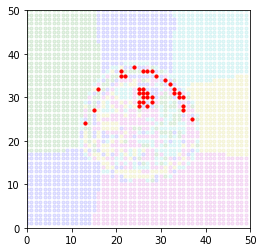

cluster: 20


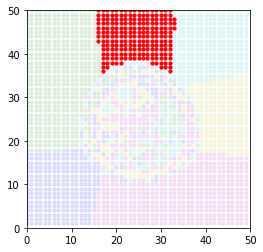

cluster: 21


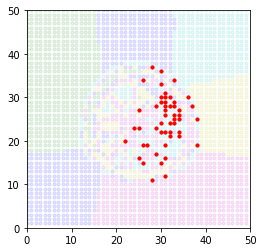

cluster: 22


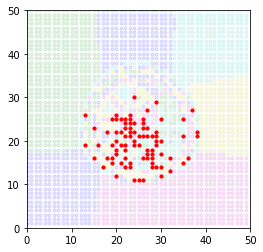

cluster: 23


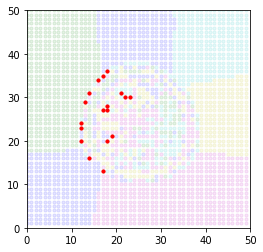

cluster: 24


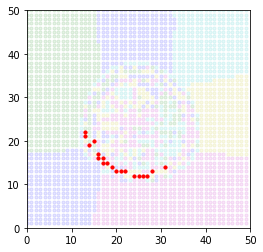

117.jpg


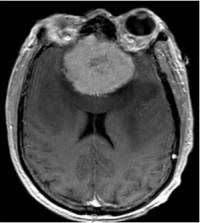

166.jpg


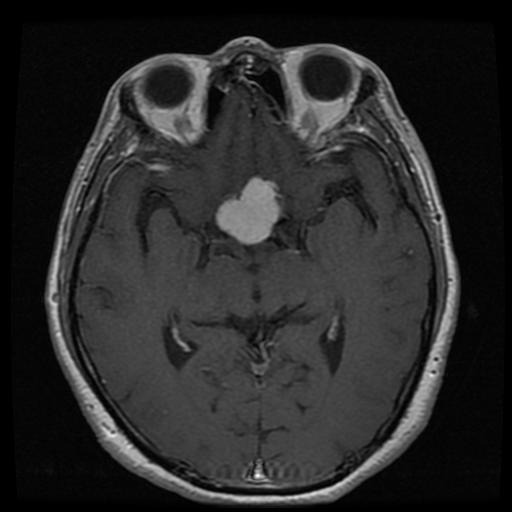

139.jpg


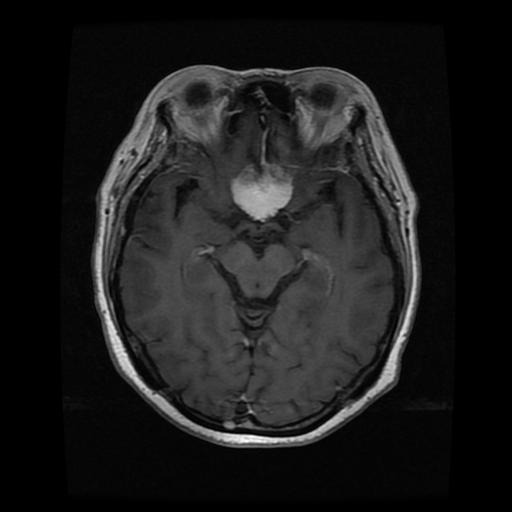

244.jpg


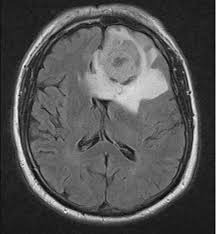

137.jpg


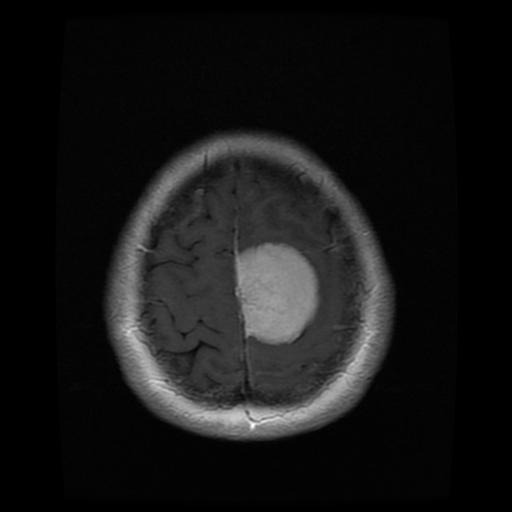

In [37]:
query(img_names, 284, 50, 50, treeKmeans, path_Kmeans, media_Kmeans, "Kmeans")

387.jpg
23 iterations
cluster: 0


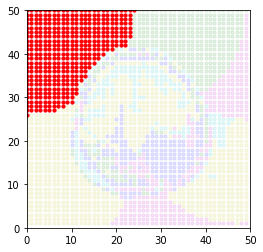

cluster: 1


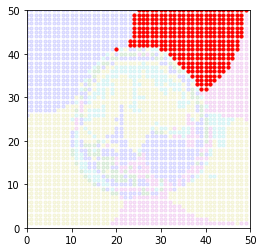

cluster: 2


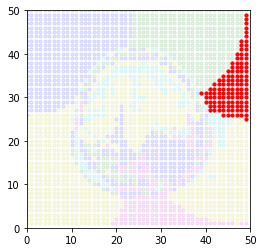

cluster: 3


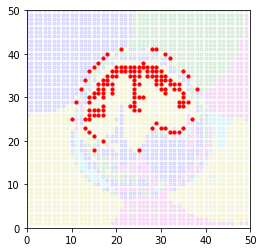

cluster: 4


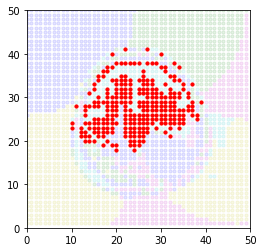

cluster: 5


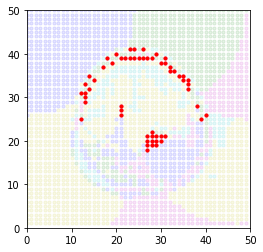

cluster: 6


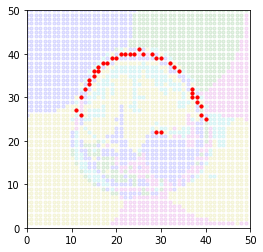

cluster: 7


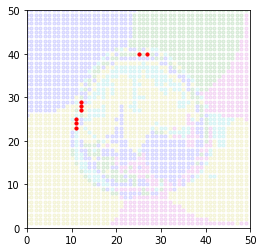

cluster: 8


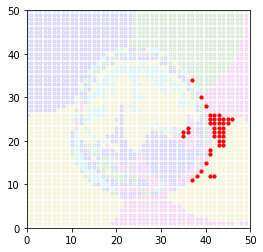

cluster: 9


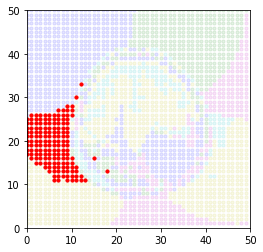

cluster: 10


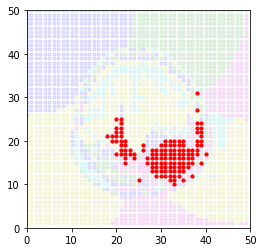

cluster: 11


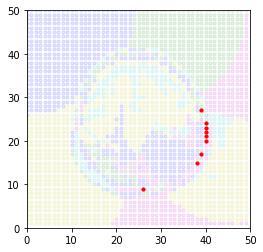

cluster: 12


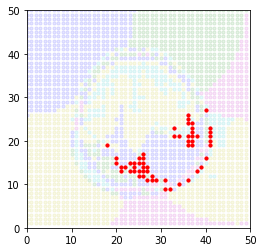

cluster: 13


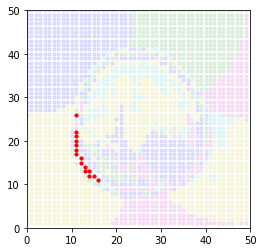

cluster: 14


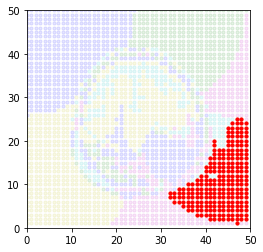

cluster: 15


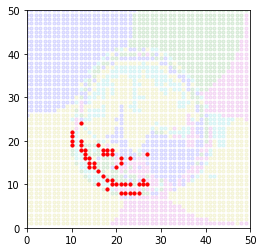

cluster: 16


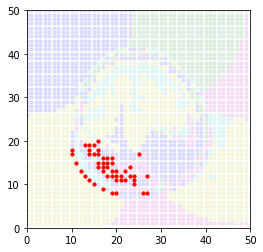

cluster: 17


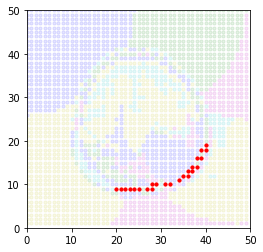

cluster: 18


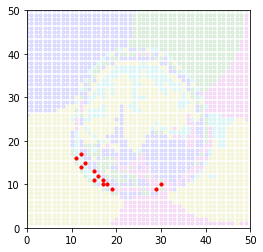

cluster: 19


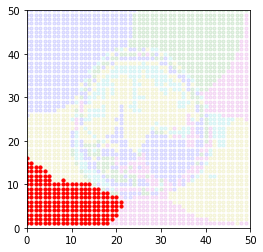

cluster: 20


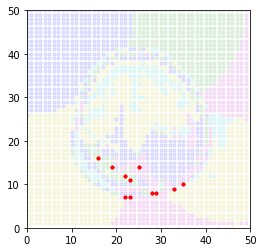

cluster: 21


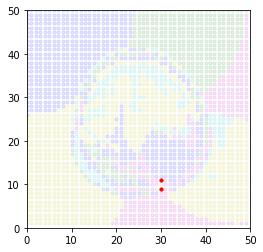

cluster: 22


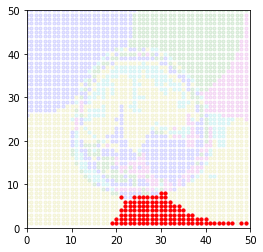

296.jpg


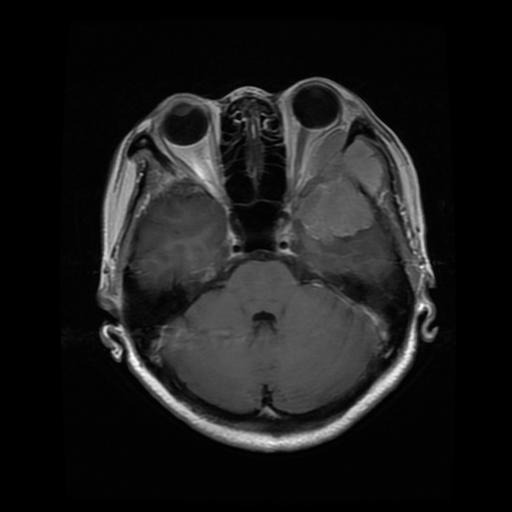

145.jpg


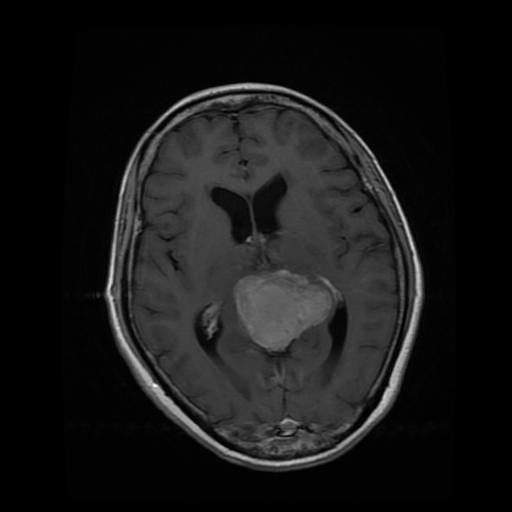

190.jpg


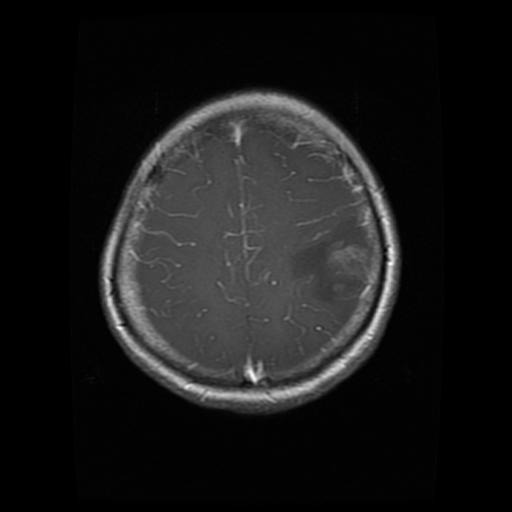

179.jpg


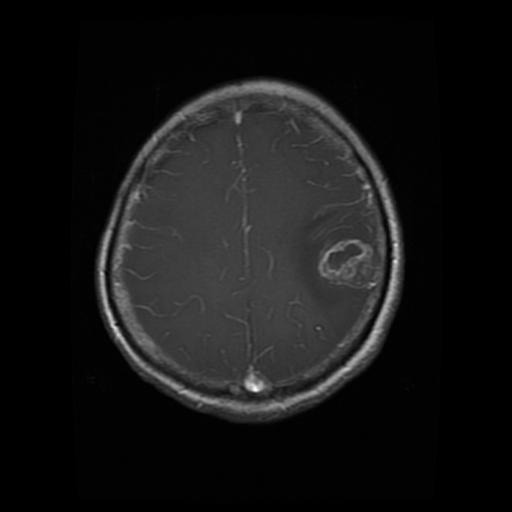

293.jpg


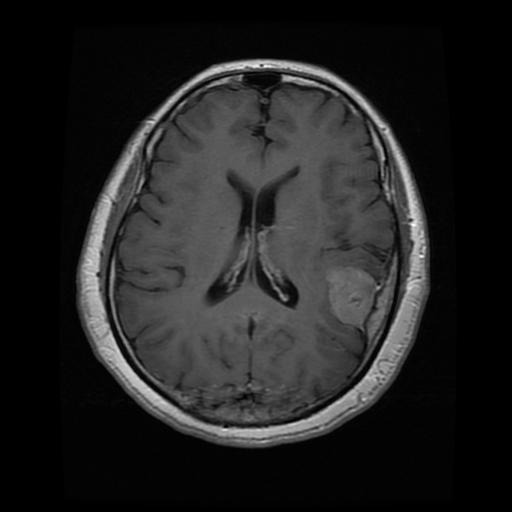

In [39]:
query(img_names, 288, 50, 50, treeDBScan, path_DBScan, media_DBScan, "DBScan")

398.jpg
27 iterations
cluster: 0


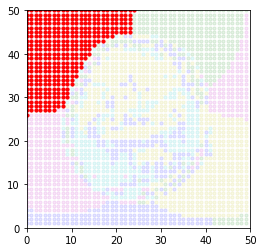

cluster: 1


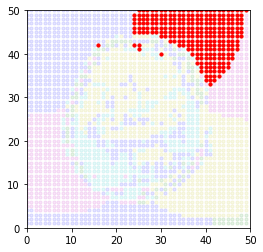

cluster: 2


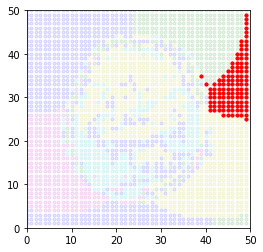

cluster: 3


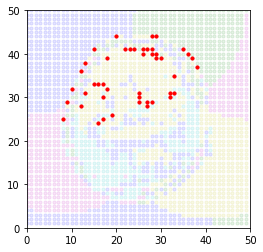

cluster: 4


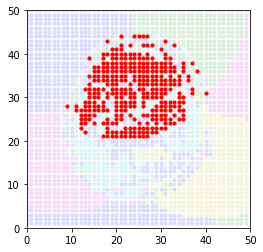

cluster: 5


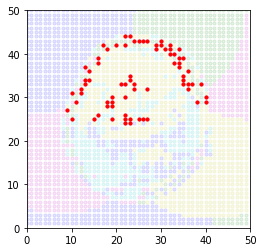

cluster: 6


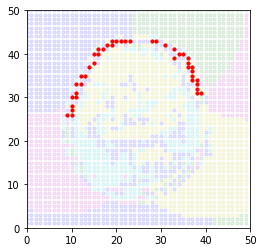

cluster: 7


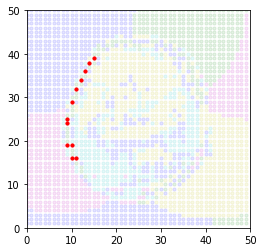

cluster: 8


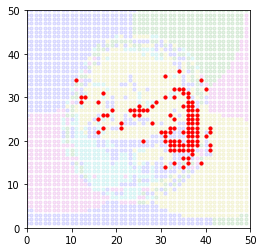

cluster: 9


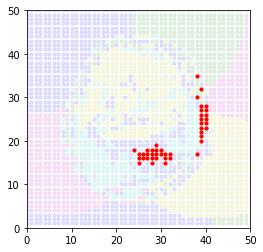

cluster: 10


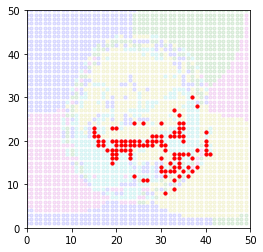

cluster: 11


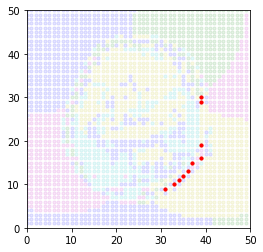

cluster: 12


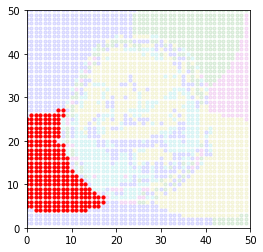

cluster: 13


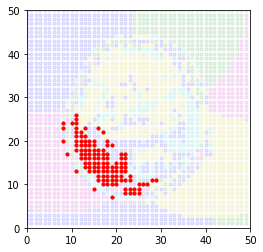

cluster: 14


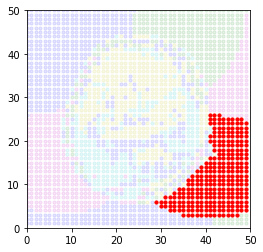

cluster: 15


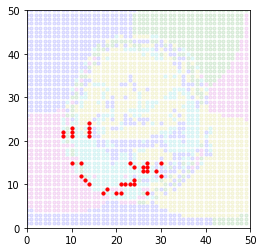

cluster: 16


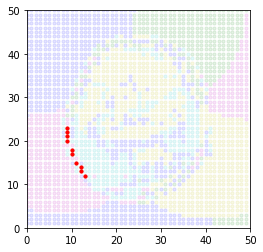

cluster: 17


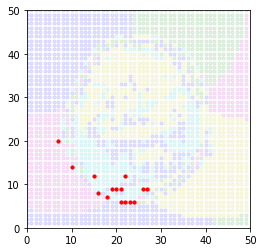

cluster: 18


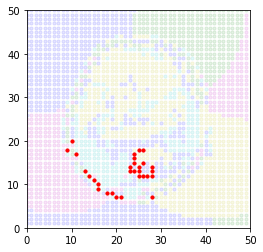

cluster: 19


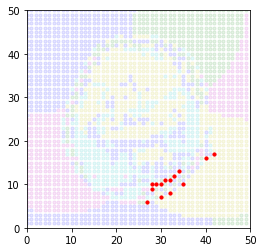

cluster: 20


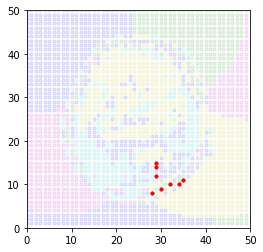

cluster: 21


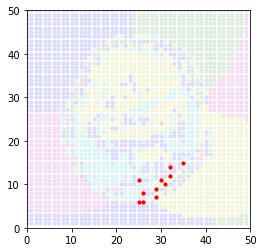

cluster: 22


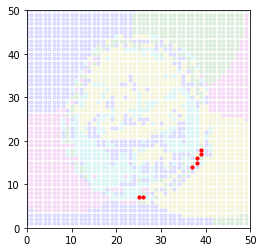

cluster: 23


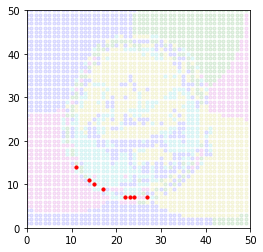

cluster: 24


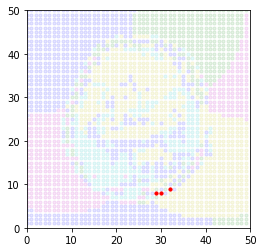

cluster: 25


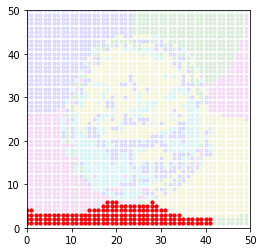

cluster: 26


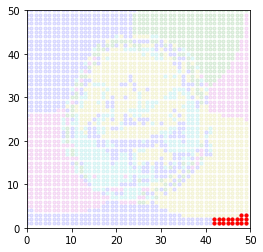

144.jpg


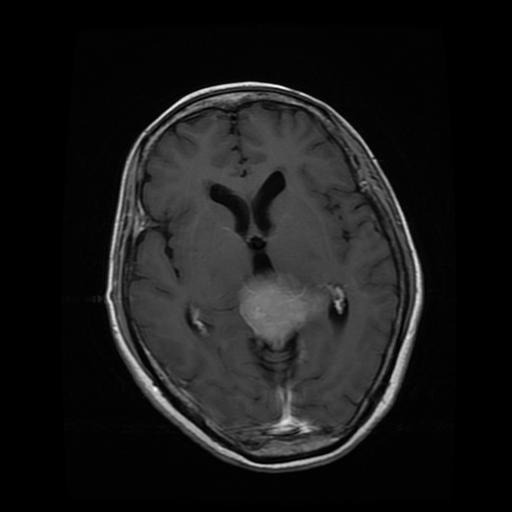

178.jpg


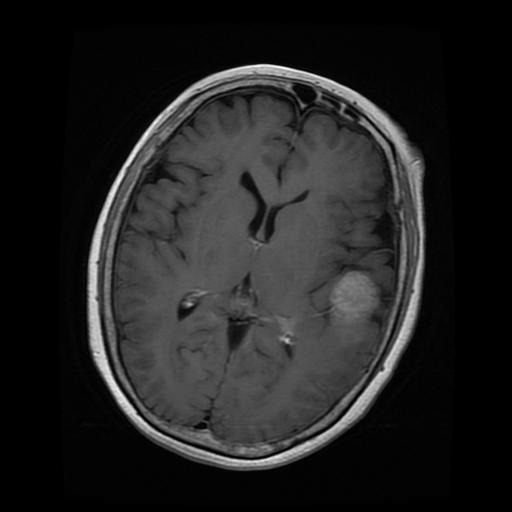

136.jpg


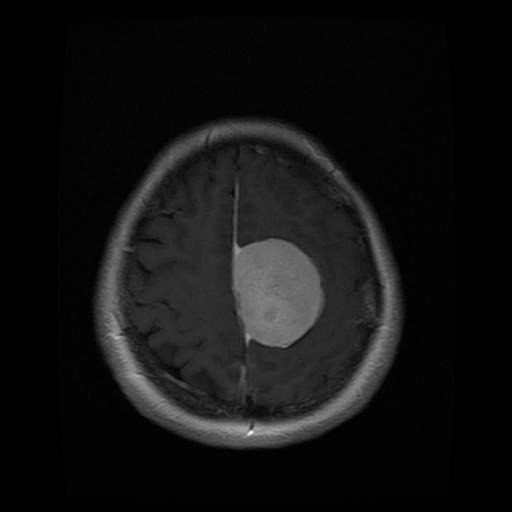

185.jpg


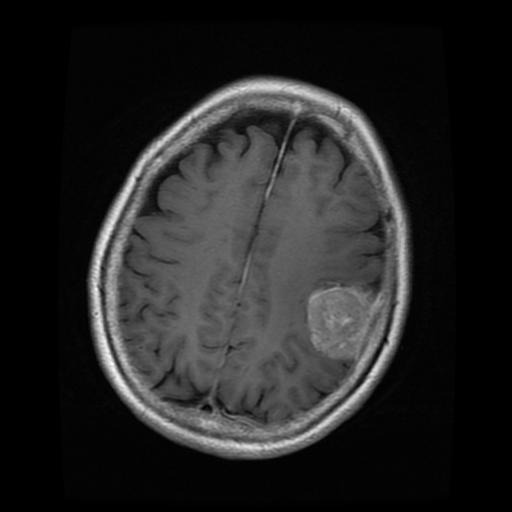

321.jpg


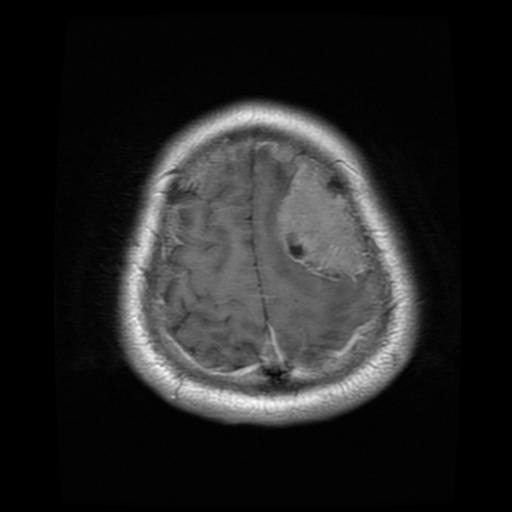

In [41]:
query(img_names, 299, 50, 50, treeDBScan, path_DBScan, media_DBScan, "DBScan")

### Homogenización por máximo de datos
Calculamos la máxima cantidad de datos de los tumores de la data en el archivo json y llevamos todos los vectores a dicho valor. Al final, obtendremos todos los vectores característicos de la misma dimensión.

### Homogenización por media de datos solo para las dos primeras dimensiones
Para ignorar el color del tumor, realizamos el mismo proceso pero solo para las dos primeras dimensiones que corresponden a las posiciones de cada pixel de los tumores.